## Criando medidas de volatilidade no Python

In [1]:
# Importa as bibliotecas
from datetime import datetime, timedelta, date 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model # roda o modelo garch
import MetaTrader5 as mt5

In [37]:
def conecta_mt5(conta):
    if conta ==  "XP-PRD":
        login = 359995
        server = "XPMT5-PRD"
        password = "Fiscal960"
    elif conta == "XP-Demo":
        login = 50359995
        server = "XPMT5-Demo"
        password = "W2585KgI"
    elif conta == "modalmais":
        login = 43292
        server = "mt5-DMA4.modalmais.com.br"
        password = "Fiscal96"
    elif conta == "MetaQuotes-Demo":
        login = 5010116048
        server = "MetaQuotes-Demo"
        password = "jpy6bivn"
    elif conta == "BTG":
        login = 2378472
        server = "BancoBTGPactual-PRD"
        password = "Fiscal960"
        
    # connect to MetaTrader 5
    if not mt5.initialize(login=login, server=server ,password=password):
        print("initialize() failed, error code =",mt5.last_error())
        mt5.shutdown()

    # request connection status and parameters
    print('Informação: trade allowed -', mt5.terminal_info().trade_allowed)


def get_ohlc(symbol, timeframe, n=5):
    # get 10 ativo D1 bars from the current day
    symbol = mt5.copy_rates_from_pos(symbol, timeframe, 0, n)
    # create DataFrame out of the obtained data
    symbol = pd.DataFrame(symbol)
    # convert time in seconds into the datetime format
    symbol['time'] = pd.to_datetime(symbol['time'], unit='s')
    symbol.set_index('time', inplace=True)
    return symbol


In [42]:
s = get_ohlc("BOVA11", mt5.TIMEFRAME_D1, 101)["close"]
s

time
2022-09-19    108.68
2022-09-20    108.75
2022-09-21    108.16
2022-09-22    109.90
2022-09-23    107.70
               ...  
2023-02-06    105.25
2023-02-07    104.10
2023-02-08    106.34
2023-02-09    104.44
2023-02-10    104.75
Name: close, Length: 101, dtype: float64

In [21]:
conecta_mt5("BTG")
ativo = "PETR4"

Informação: trade allowed - True


In [22]:
def ohlc_to_ascending_df(ativo):
    ohlc = get_ohlc(ativo, mt5.TIMEFRAME_D1, 101)["close"]
    ohlc = ohlc.to_frame()
    ohlc.index.names = ['Date']
    ohlc.sort_values('Date', ascending=False, inplace=True)
    return ohlc

ohlc = ohlc_to_ascending_df(ativo)

In [23]:
def get_log_return(df):
    data = df.copy()
    # Transforma em retornos contínuos
    data['log_return'] = np.log( data['close'].shift(-1) / data['close'])
    data.dropna(inplace=True)
    data.sort_values('Date', inplace=True)
    return(data)

data = get_log_return(ohlc)

In [24]:
data

,close,log_return
Date,,
2022-09-20,31.00,0.011865
2022-09-21,31.20,-0.006431
2022-09-22,31.91,-0.022501
2022-09-23,29.84,0.067070
2022-09-26,29.33,0.017239
...,...,...
2023-02-06,25.78,-0.039159
2023-02-07,25.62,0.006226
2023-02-08,26.05,-0.016644


In [25]:
def get_std_dev(df):
    # compute sample standard deviation of returns
    data = df.copy()
    data['std_dev'] = data['log_return'].rolling(50).std()
    return(data)

data = get_std_dev(data)

In [26]:
def hist_volatility(df):
    # hystorycal annualized volatilty
    data = df.copy()
    data['hist_volatility'] = data['std_dev'] * ((252)**0.5)
    # Retira os dados faltantes
    data = data.dropna()
    return(data)

data = hist_volatility(data)
data

,close,log_return,std_dev,hist_volatility
Date,,,,
2022-12-01,25.59,0.040963,0.040023,0.635340
2022-12-02,25.91,-0.012427,0.040074,0.636148
2022-12-05,25.62,0.011256,0.040061,0.635955
2022-12-06,25.64,-0.000780,0.039886,0.633174
2022-12-07,25.35,0.011375,0.038864,0.616950
2022-12-08,24.78,0.022742,0.038912,0.617715
2022-12-09,24.71,0.002829,0.038863,0.616937
2022-12-12,23.91,0.032911,0.039056,0.620002
2022-12-13,23.32,0.024985,0.039151,0.621507


##### Com a série em mãos, agora é necessário especificar o modelo utilizando arch_model. Além da série de retornos, escolhemos a ordem de p e q como 1, pois utilizaremos um GARCH(1,1). A média será constante e tomaremos a distribuição dos resíduos padronizados como normal.

In [27]:
def garch_model(df):
    # Especifica o modelo
    gm = arch_model(df['log_return'], p = 1, q = 1,
                        mean = 'constant', vol = 'GARCH', dist = 'normal', rescale=False)
    # Roda o modelo
    gm_fit = gm.fit(disp = 'off')
    print(gm_fit.summary())
    return gm_fit

gm_fit = garch_model(data)

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                111.814
Distribution:                  Normal   AIC:                          -215.628
Method:            Maximum Likelihood   BIC:                          -207.901
                                        No. Observations:                   51
Date:                Sun, Feb 12 2023   Df Residuals:                       50
Time:                        21:25:21   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.4424e-05  3.805e-03 -1.956e-02      0.

##### Escolhido as configurações do modelo, "rodamos" ele com o método fit() e obtemos os resultados utilizando métodos e atributos do objeto. Através de params, obtemos os valores dos parâmetros estimados. Caso queiramos ver todos os valores produzidos, utilizamos summary().

In [28]:
# Visualiza os parâmetros
gm_fit.params

mu         -7.442398e-05
omega       4.580495e-04
alpha[1]    2.412405e-11
beta[1]     3.678727e-01
Name: params, dtype: float64

In [29]:
# Sumariza os resultados
print(gm_fit.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                111.814
Distribution:                  Normal   AIC:                          -215.628
Method:            Maximum Likelihood   BIC:                          -207.901
                                        No. Observations:                   51
Date:                Sun, Feb 12 2023   Df Residuals:                       50
Time:                        21:25:21   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -7.4424e-05  3.805e-03 -1.956e-02      0.

<AxesSubplot: xlabel='Date'>

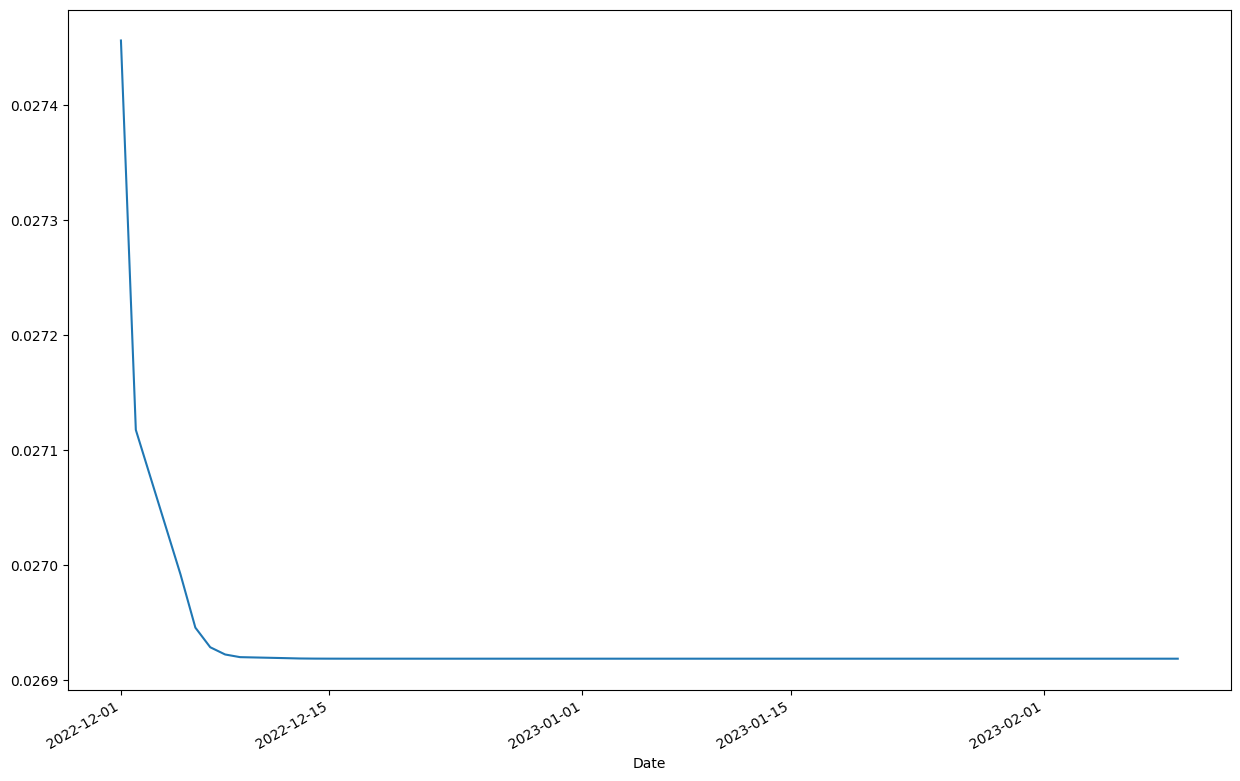

In [30]:
# Plota 
plt.figure(figsize=(15,10))
gm_fit.conditional_volatility.plot()

In [31]:

gm_fit.conditional_volatility

Date
2022-12-01    0.027456
2022-12-02    0.027118
2022-12-05    0.026992
2022-12-06    0.026946
2022-12-07    0.026929
2022-12-08    0.026922
2022-12-09    0.026920
2022-12-12    0.026919
2022-12-13    0.026919
2022-12-14    0.026919
2022-12-15    0.026919
2022-12-16    0.026919
2022-12-19    0.026919
2022-12-20    0.026919
2022-12-21    0.026919
2022-12-22    0.026919
2022-12-23    0.026919
2022-12-26    0.026919
2022-12-27    0.026919
2022-12-28    0.026919
2022-12-29    0.026919
2023-01-02    0.026919
2023-01-03    0.026919
2023-01-04    0.026919
2023-01-05    0.026919
2023-01-06    0.026919
2023-01-09    0.026919
2023-01-10    0.026919
2023-01-11    0.026919
2023-01-12    0.026919
2023-01-13    0.026919
2023-01-16    0.026919
2023-01-17    0.026919
2023-01-18    0.026919
2023-01-19    0.026919
2023-01-20    0.026919
2023-01-23    0.026919
2023-01-24    0.026919
2023-01-25    0.026919
2023-01-26    0.026919
2023-01-27    0.026919
2023-01-30    0.026919
2023-01-31    0.026919
2023-0

In [32]:
def gm_volatility(gm_fit):
    gm_volatility = gm_fit.conditional_volatility * 252 ** 0.5
    gm_volatility = pd.DataFrame({'gm_volatility':gm_volatility.values}, index=gm_volatility.index)
    gm_volatility.sort_index(ascending=False, inplace=True)
    return(gm_volatility)

gm_volatility = gm_volatility(gm_fit)
gm_volatility

,gm_volatility
Date,
2023-02-10,0.427321
2023-02-09,0.427321
2023-02-08,0.427321
2023-02-07,0.427321
2023-02-06,0.427321
2023-02-03,0.427321
2023-02-02,0.427321
2023-02-01,0.427321
2023-01-31,0.427321


##### Por fim, é possível realizar a previsão da variância utilizando o método forecast().



In [33]:
def forecast_vol(gm_fit, horizon = 1):
    # Previsão
    forecast = gm_fit.forecast(horizon=horizon, reindex = False)
    forecast.variance
    forecast_vol = (forecast.variance ** 0.5) * 252 ** 0.5
    return(forecast_vol)

forecast_vol = forecast_vol(gm_fit)
forecast_vol

,h.1
Date,
2023-02-10,0.427321


In [34]:
def volatilites(data):
    forecast_data = data.sort_index(ascending=False)
    garch_vol = forecast_data.join(gm_volatility).join(forecast_vol).fillna('-')
    vols = garch_vol.iloc[0,:].to_frame().T
    return vols

vols = volatilites(data)

In [36]:
vols['gm_volatility'][0]

0.4273209631936028

In [35]:
vols

,close,log_return,std_dev,hist_volatility,gm_volatility,h.1
2023-02-10,26.72,-0.030012,0.026926,0.427442,0.427321,0.427321
